## Expresiones cuadraticas

In [8]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
from copy import copy
from typing import List
mpl.rcParams['figure.dpi'] = 300
import networkx as nx
import matplotlib.pyplot as plt

### MaxCut
En el problema MaxCut, los valores o datos de entrada es una grafica (posiblemente con pesos asignados) y se busca encontrar la particion de los vertices en la grafica en dos conjuntos. La particion se hace de tal manera que la suma cumulativa del peso de las conexiones entre los vertices es maximizada. <br>

El grafo definido por el conjunto $G=(V,E)$ es una grafica con $n$ vertices. Si numeramos los vertices $v_1, \dots, v_n$, y asignamos a cada vertice el valor 0 o 1 dependiendo de su asignacion a un grupo, obtenemos un vector $x \in \{0,1\}^n$. Entonces podemos definir la siguiente funcion de costo:
$$
C(x) = \sum_{i,j=1}^n W_{ij} x_i (1-x_j)
$$
donde $W_{ij} = W_{ji}$ determina el peso de la conexion entre dos vertices $v_i$ y $v_j$, y $W_{ij} = 0$ si $v_i$ y $v_j$ no estan conectadas. <br>

Empezamos por definir una grafica:

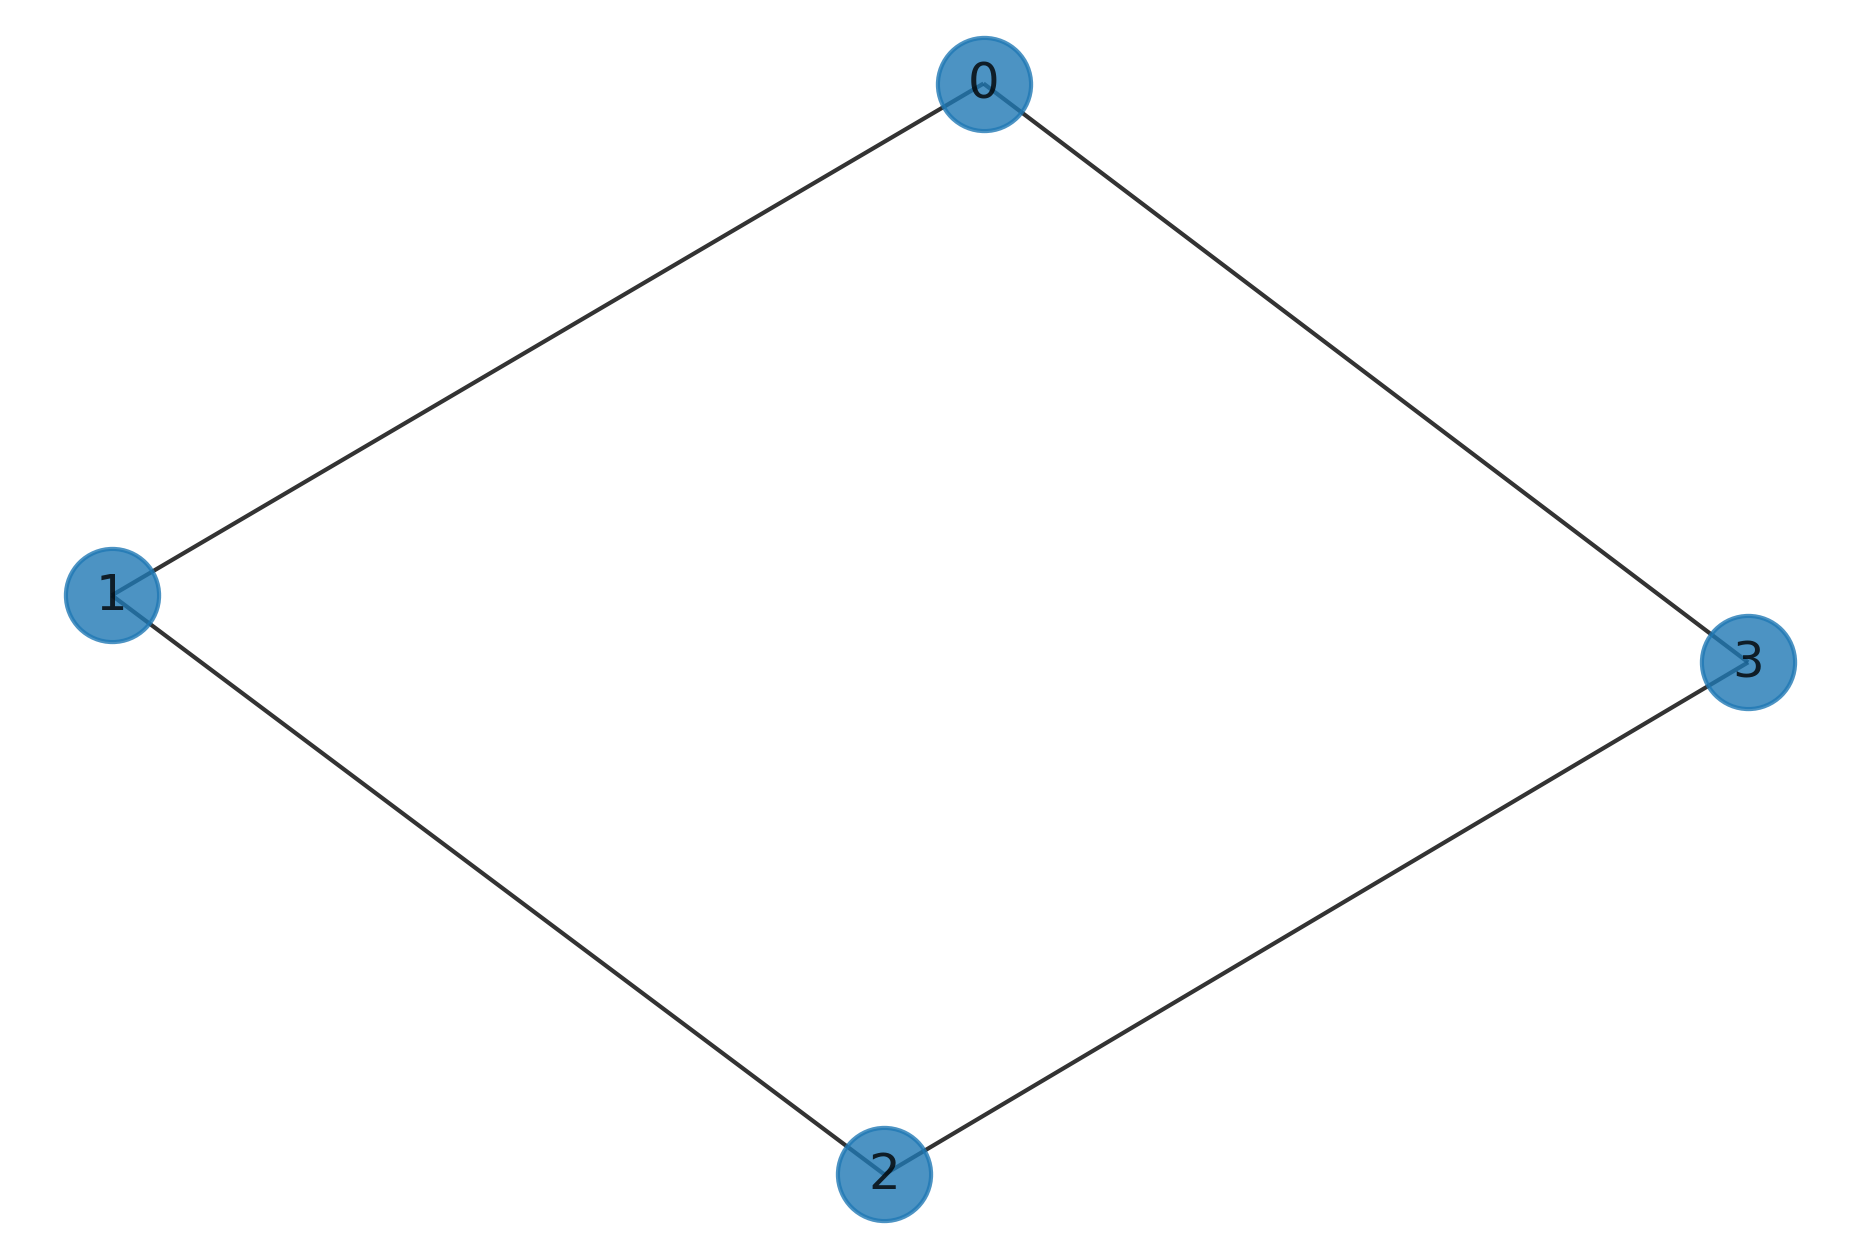

In [9]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)


Ahora implementamos el circuito para el operador tipo mixer:

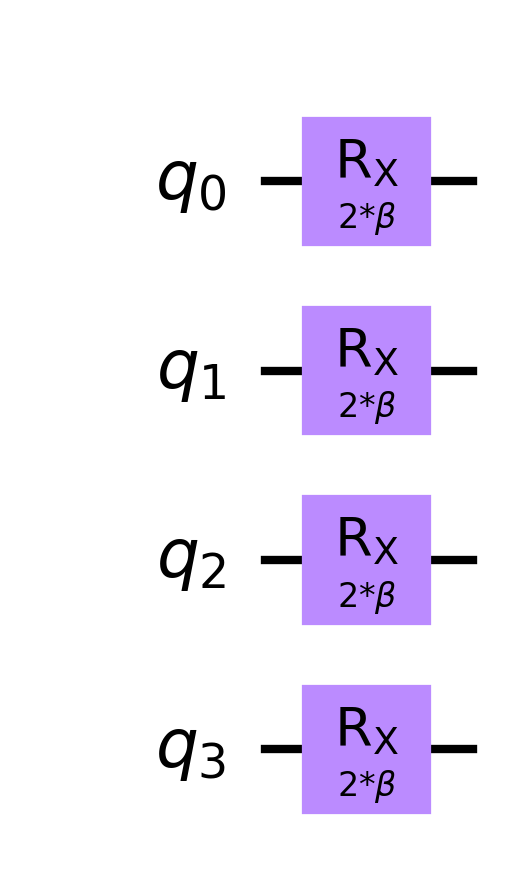

In [14]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

y luego el operador que contiene la solucion al problema:

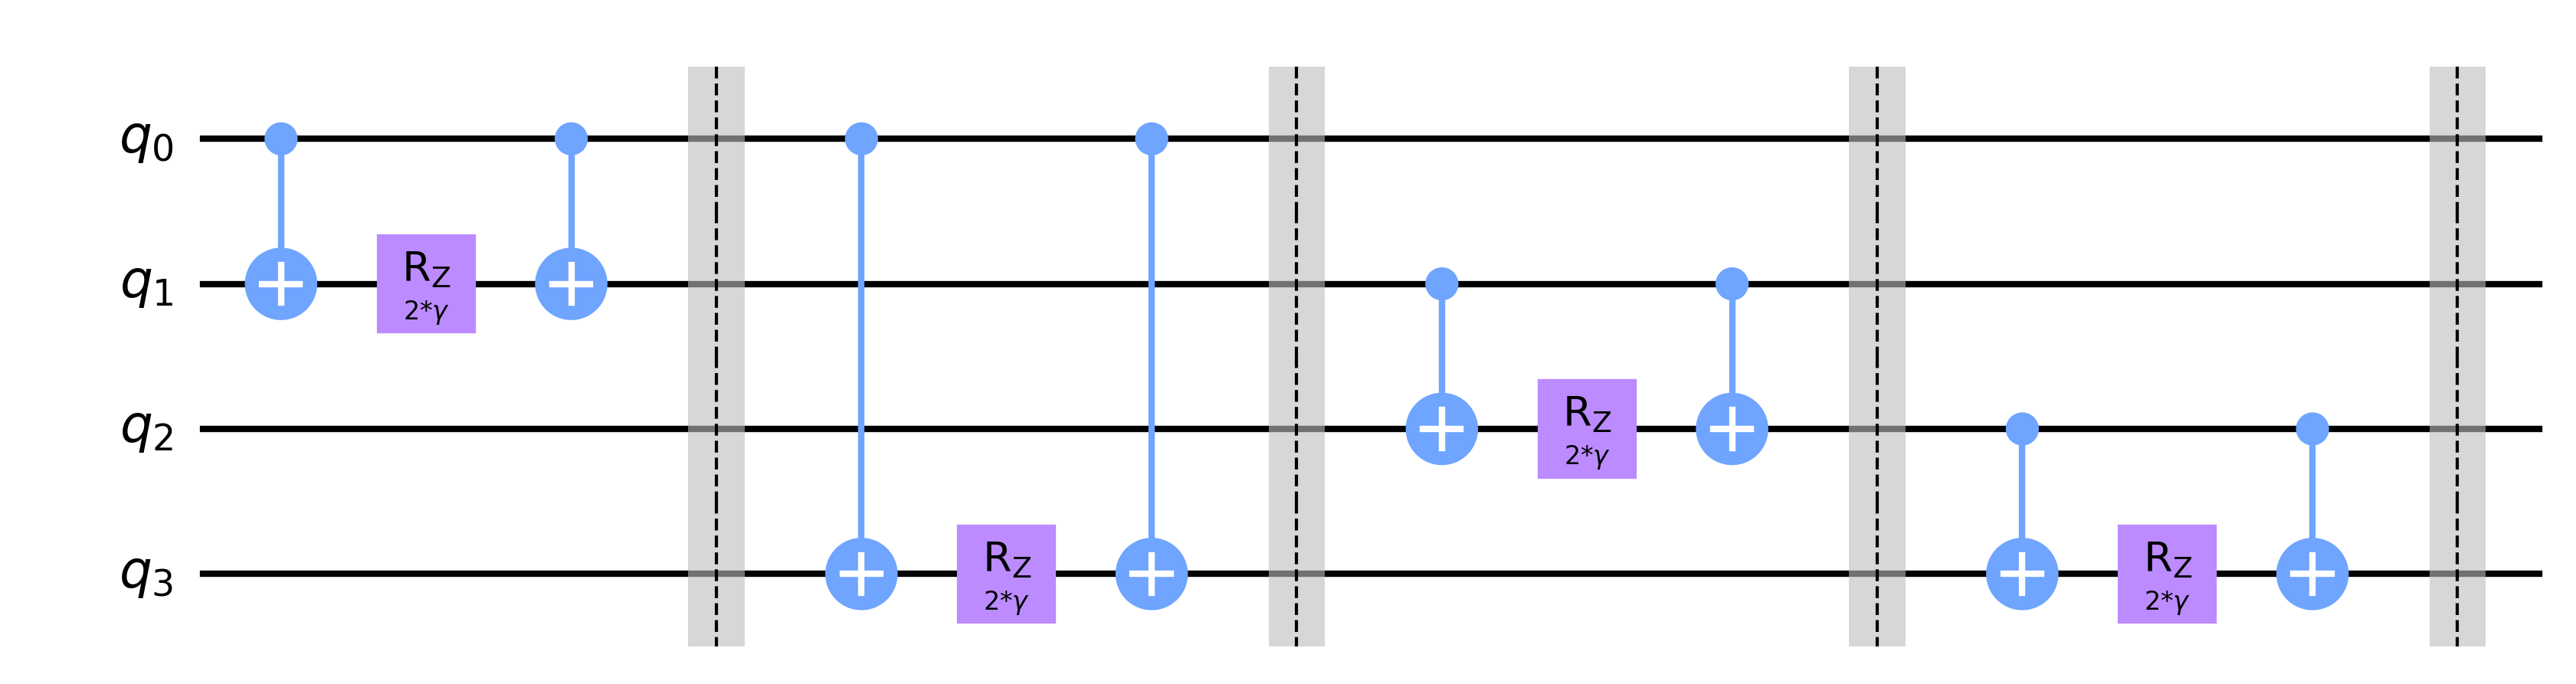

In [13]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw('mpl')

Ahora inicializamos nuestro sistema en superposicion:

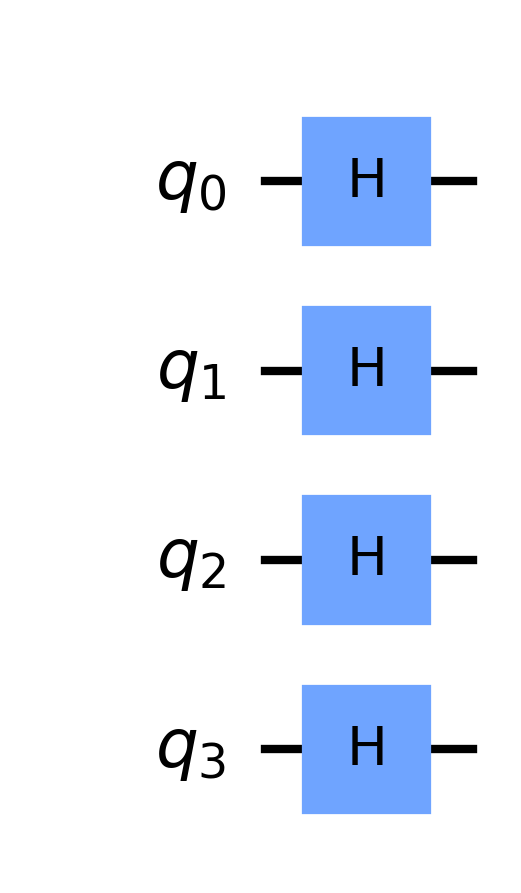

In [16]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

Ahora utilizamos todos estos componentes para formar el circuito QAOA

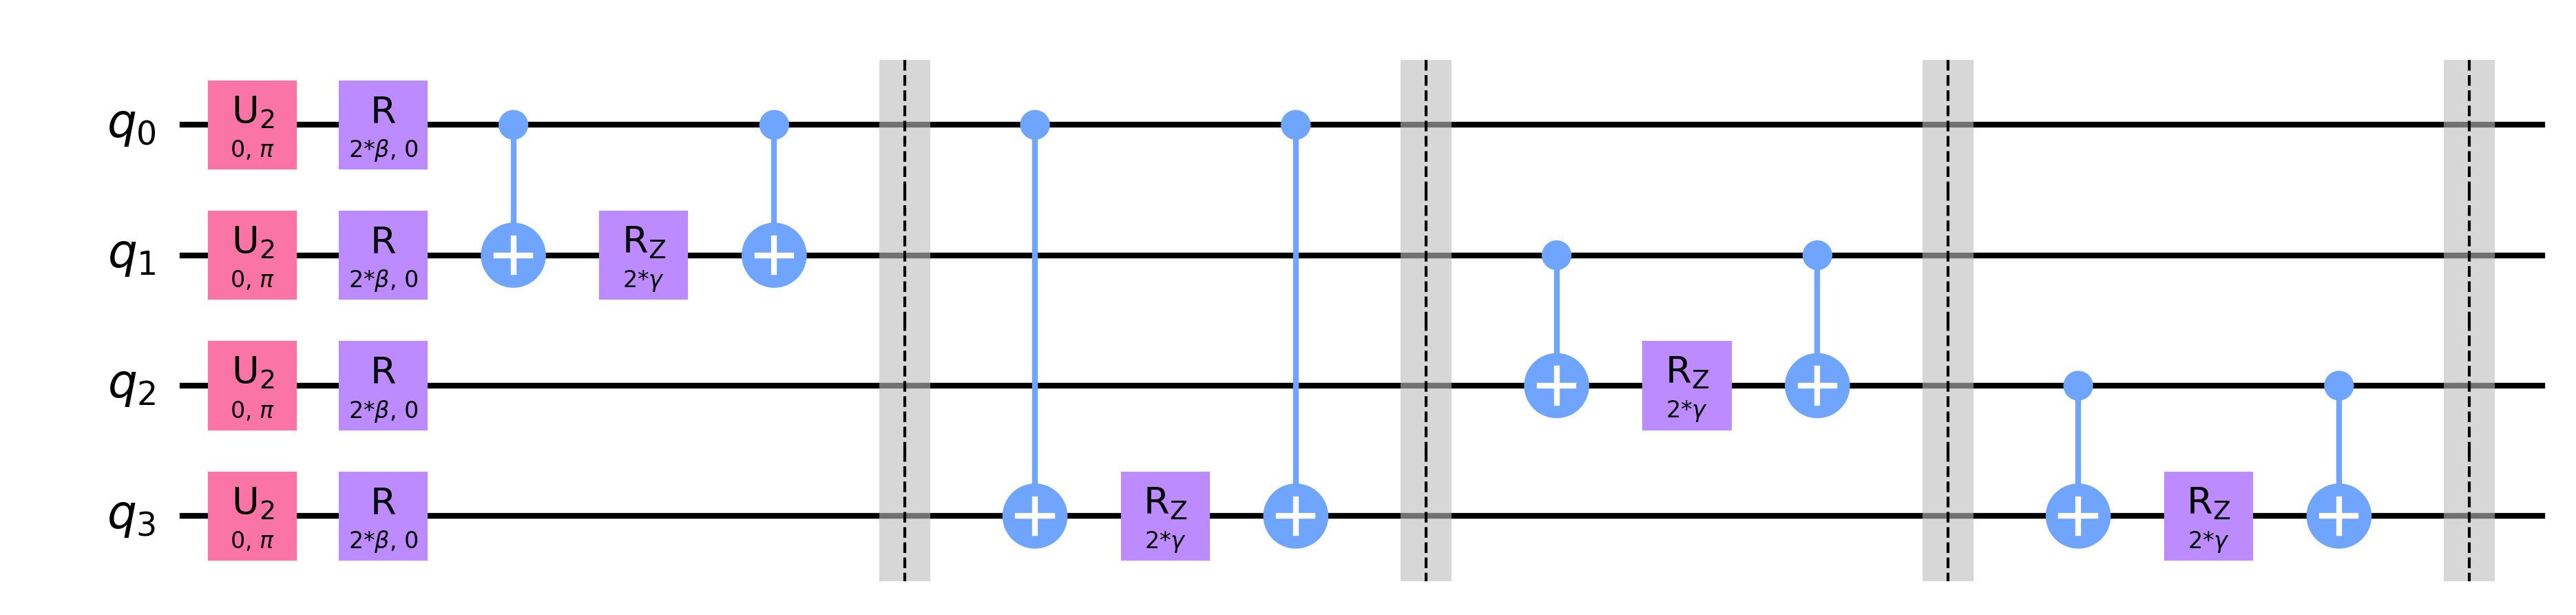

In [18]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw('mpl')

In [20]:
def maxcut_obj(x,G):
    obj = 0
    for i,j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    
    return obj

In [21]:
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
    
    return avg/sum_count


In [30]:
def create_qaoa_circ(G, theta):
    nqubits = len(G.nodes())
    p = len(theta)//2
    qc = QuantumCircuit(nqubits)

    beta = theta[:p]
    gamma = theta[p:]

    # estado inicial
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

    qc.measure_all()

    return qc

In [31]:
def get_expectation(G, p, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):

        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)

    return execute_circ

In [32]:
from scipy.optimize import minimize

In [33]:
expectation = get_expectation(G, p=1)

In [34]:
res = minimize(expectation, [1.0,1.0], method='COBYLA')

In [35]:
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

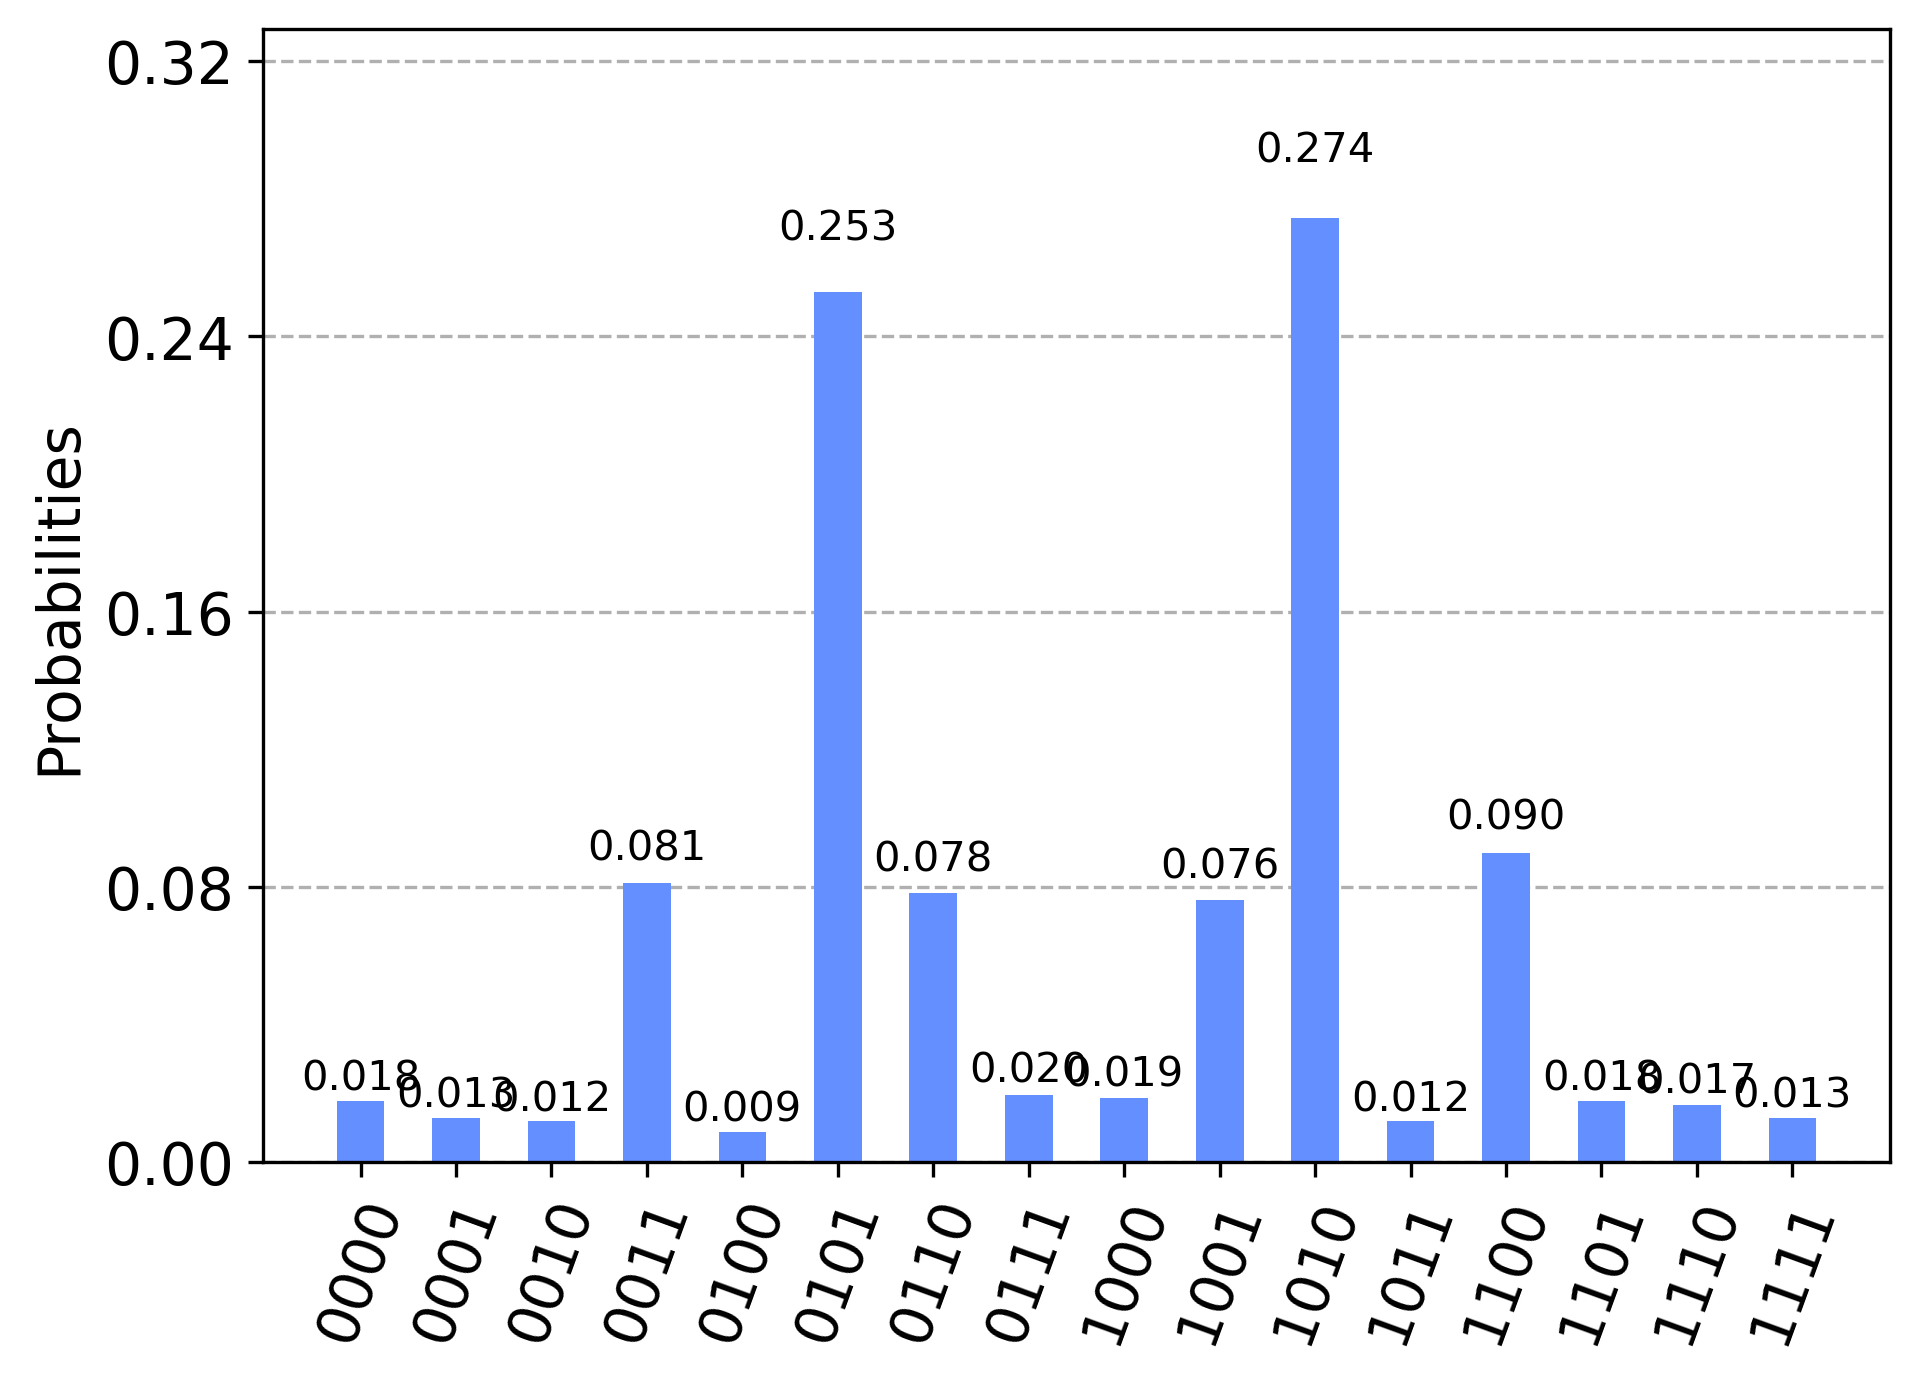

In [36]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

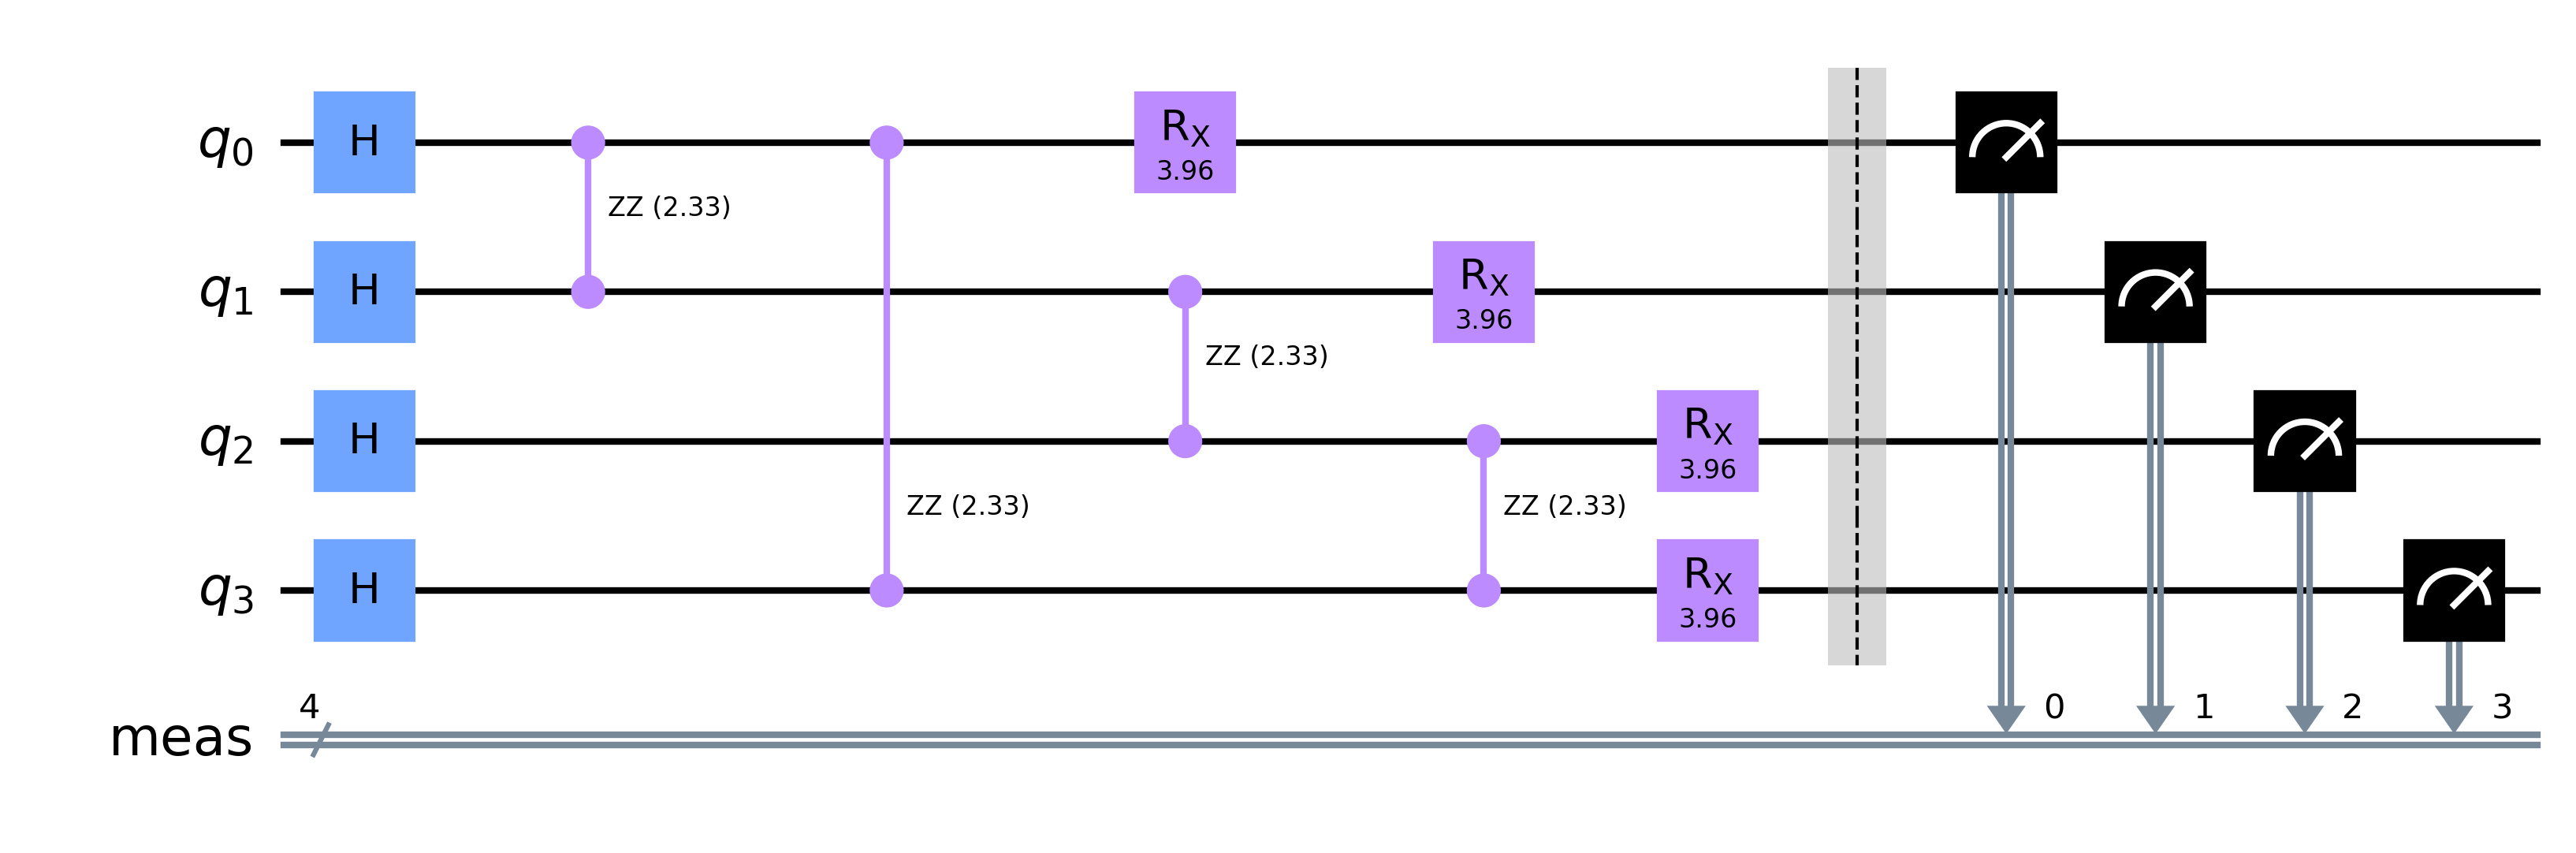

In [38]:
qc_res.draw('mpl')